In [ ]:
# Two data sets (before, after)
# objective function: h = n repetitions of f,  where f = g(t)-g(t+T)   
# full data identification (time window defined but not used )
# Identifies "a repetitive" pattern on the full data set ( it also works on a smaller data window )

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pprint

import cma

In [427]:
# import data
data_frame = pd.read_csv('All_data.csv', sep=',')

In [428]:
data = data_frame.to_numpy()
t, v = data[:, 0], data[:, 1]

In [429]:
# data_frame2 = pd.read_csv('t0.csv', sep=',')

In [430]:
# data2 = data_frame2.to_numpy()
# t0_idx, t0  = data2[:, 0], data2[:, 1]
# t0_idx = np.array([int(t0_id) for t0_id in t0_idx])

<IPython.core.display.Javascript object>


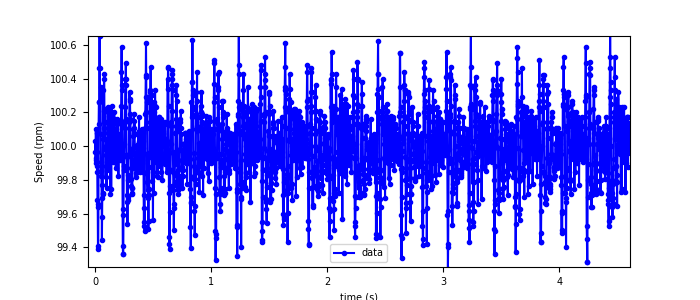

In [431]:
# display data
plt.rcParams['figure.figsize'] = [7, 3]
# %matplotlib notebook

#plt.plot(t, v, 'b-o', t[t0_idx], 100*np.ones(len(t0)),'r*')
plt.plot(t, v, '-b.')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data'])
plt.show()

In [410]:
# expected value of the parameters:
# A = 0.6
# t0 = 0.216
# tau = 9
# omega = 2*np.pi*26
# c = 100
# t1 = 0.41
# t2 = 0.216
# T = 0.5
# TT = 1

# n_max = 4




def media(v):
   return sum(v)/len(v)

def RMSE(v,v_hat):
      return np.sqrt(((v-v_hat)**2).mean())

def step(x):
    return 1*(x>0)


## 'couple' pattern: interpolating func f = g(t)-g(t+T)  
# where g = A *step(t-t0-t2) *step(t1-(t-t0)) *np.exp(-1*(t-t0-t2)*tau) *np.sin(omega*(t-t0))
# single positive:  g(t)
# single negative: -g(t)

# single positive
def g(A, t0, tau, omega, c, t1, t2): # c not used here
    return A *step(t-t0-t2) *step(t1-(t-t0)) *np.exp(-1*(t-t0-t2)*tau) *np.sin(omega*(t-t0))

# single positive + single negative
def f(A, t0, tau, omega, c, t1, t2, T):   #par = [A, t0, tau, omega, c, t1, t2, T]
    return (g(A, t0, tau, omega, c, t1, t2)-g(A, t0+T, tau, omega, c, t1, t2))+c

# objective function defined on 'couple' pattern
def obj2(par):
    [A, t0, tau, omega, c, t1, t2, T] = par
    return RMSE(v, f(A, t0, tau, omega, c, t1, t2, T))



## 'repetitive' pattern: interpolating func h = f(t) + f(t+TT)+ ...  
# h = n repetitons of (single positive + single negative) couple
# h(A, t0, tau, omega, c, t1, t2, T, TT) =   
#    (f(A, t0, tau, omega, 0, t1, t2, T) +f(A, t0+TT, tau, omega, 0, t1, t2, T)) +c

# 'repetitive' pattern:
def h(A, t0, tau, omega, c, t1, t2, T, TT): 
    n_max = 4 # int(par[8])
    a = c
    for n in range (0,n_max):
        period = n*TT
        a = a + f(A, t0+period, tau, omega, 0, t1, t2, T)
    return a 

# objective function defined on 'repetitive' pattern
def obj3(par):
    [A, t0, tau, omega, c, t1, t2, T, TT] = par
    return RMSE(v, h(A, t0, tau, omega, c, t1, t2, T, TT))


<IPython.core.display.Javascript object>


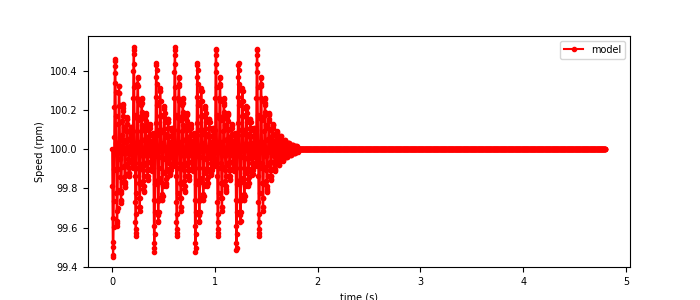

In [432]:
# for debug:
# interpolating function plot

#plt.rcParams['figure.figsize'] = [6, 3]
# %matplotlib inline

# expected value of the parameters
A = -0.6
t0  = 0
tau = 9
omega = 2*np.pi*26
c = 100
t1 = 0.41
t2 = 0
T = 0.20
TT = 0.40
# n_max = 12

#par = [A, t0, tau, omega, c, t1, t2, T]

plt.plot(t, h(A, t0, tau, omega, c, t1, t2, T, TT), '-r.') #,t, v, 'b-o')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['model'])
plt.show()

<IPython.core.display.Javascript object>


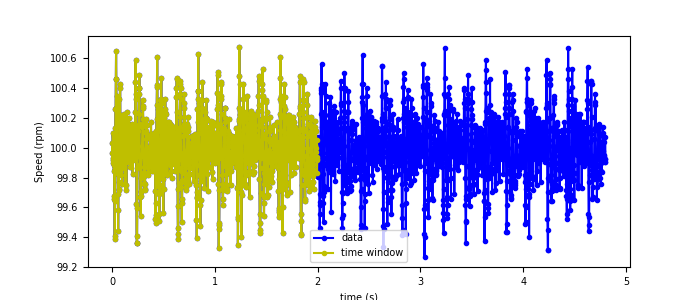

In [433]:
# time window on data

T = 0.20 # period
dT = 0.002; # sampling time

num = 10
window_samples = int(num*T/0.002) 

v_w = v[0:window_samples]
t_w = t[0:window_samples]

plt.plot(t,v, '-b.',t_w,v_w,'-y.')#,t, v, 'b-o')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data','time window'])
plt.show()

t = t_w
v = v_w


In [415]:
# domain of the variables

#domain= [[m0, m1, m2, m3, m4, m5, m6],[M0, M1, M2, M3, M4, M5, M6]]
A_b = [-(max(v)-min(v))/2, (max(v)-min(v))/2]
t0_b = [min(t), max(t)]
tau_b = [5, 30]
omega_b = [ 2*np.pi*1, 2*np.pi*40]
c_b = [min(v), max(v)]
t1_b = [0, 0.204] # to be set
t2_b = [0, 0.204/2] # to be set
T_b = [min(t), max(t)] # to be set
TT_b = [min(t), max(t)] # to be set

domain = np.array([[A_b[0], t0_b[0], tau_b[0], omega_b[0], c_b[0], t1_b[0], t2_b[0], T_b[0], TT_b[0]], [A_b[1], t0_b[1], tau_b[1], omega_b[1], c_b[1], t1_b[1], t2_b[1], T_b[1], TT_b[1]]] )


In [416]:
# obj3 -- 'repetitive' pattern identification

#x0 = (m+M)/2
#sigma0 = (M-m)/4
x0 = (domain[0]+domain[1])/2
sigma0 = (domain[1]-domain[0])/4    


#res = cma.CMAEvolutionStrategy(x0, 1, inopts={'popsize':2000, 'CMA_stds':sigma0,'fixed_variables':{5:0.218, 6:0, 7:0.204}}) 
res = cma.CMAEvolutionStrategy(x0, 1, inopts = {'popsize':3500, 'CMA_stds':sigma0, 'bounds':[domain[0], domain[1]], 'fixed_variables':{ 7:0.20, 8:0.4}}) 
res.optimize(obj3, iterations=2000)

(1750_w,3500)-aCMA-ES (mu_w=881.6,w_1=0%) in dimension 7 (seed=900856, Tue Mar  5 15:43:23 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1   3500 2.037903999913636e-01 1.0e+00 1.03e+00  3e-02  6e+01 0:05.0
    2   7000 1.955699722047680e-01 4.6e+00 1.07e+00  3e-02  6e+01 0:07.7
    3  10500 1.861984749906720e-01 1.4e+01 1.12e+00  2e-02  6e+01 0:10.4
    4  14000 1.755597192568300e-01 2.6e+01 1.21e+00  1e-02  6e+01 0:14.9
    6  21000 1.817985505792024e-01 5.2e+01 1.39e+00  1e-02  6e+01 0:20.8
    8  28000 1.527433102351001e-01 6.9e+01 1.55e+00  9e-03  5e+01 0:26.3
   11  38500 1.703614797706452e-01 7.9e+01 1.74e+00  8e-03  3e+01 1:29.7
   14  49000 1.668472428920898e-01 9.3e+01 1.94e+00  7e-03  2e+01 1:37.8
   17  59500 1.669166179394579e-01 9.7e+01 2.12e+00  7e-03  2e+01 1:46.3
   21  73500 1.653843148515164e-01 9.0e+01 2.34e+00  8e-03  1e+01 3:16.3
   25  87500 1.584689384129447e-01 8.5e+01 2.47e+00  8e-03  1e+01 3:28.8
   30 105000 1.5353475781019

<IPython.core.display.Javascript object>


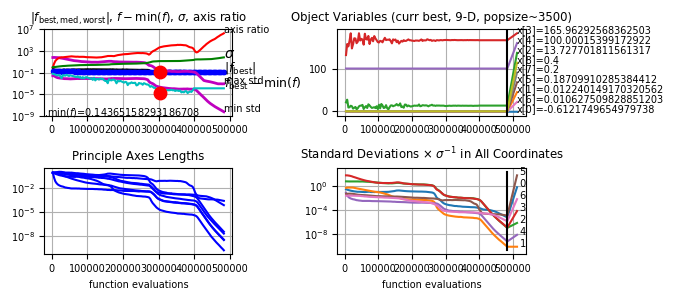

In [417]:
%matplotlib notebook
cma.plot()

In [418]:
res.result_pretty()

termination on tolfunhist=1e-12
final/bestever f-value = 1.437753e-01 1.436516e-01
incumbent solution: [-0.6120099291561505, 0.012240149123769814, 13.727703362975351, 165.96292610384032, 100.00015400065213, 0.18680599616868393, 0.010647186458342678, 0.2, 0.4]
std deviation: [0.00042883169530461674, 5.6002464807684955e-09, 7.721079917692596e-06, 8.44097320081815e-06, 4.1764829024794394e-08, 0.0008513109191574861, 9.701667258509109e-05]


CMAEvolutionStrategyResult(xbest=array([-5.94292760e-01,  1.23877717e-02,  1.30464138e+01,  1.66413495e+02,
        9.99994057e+01,  1.48705476e-01,  1.11546608e-02,  2.00000000e-01,
        4.00000000e-01]), fbest=0.14365158293186708, evals_best=303300, evaluations=483000, iterations=138, xfavorite=array([-6.13275618e-01, -9.94775689e-02,  1.37277034e+01,  1.65962926e+02,
        1.00000150e+02,  3.28545288e-01, -3.85417363e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([4.28831695e-04, 5.60024648e-09, 7.72107992e-06, 8.44097320e-06,
       4.17648290e-08, 8.51310919e-04, 9.70166726e-05]))

In [419]:
out = res.result.xbest

print('out = [A, t0, tau, omega, c, t1, t2, T] =' ) 
print('    =', out)
print('expected values = [-0.6, 0, 9, 2*pi*26, 100, 0.218, 0, 0.204]')
print('error =', obj3(out))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-5.94292760e-01  1.23877717e-02  1.30464138e+01  1.66413495e+02
  9.99994057e+01  1.48705476e-01  1.11546608e-02  2.00000000e-01
  4.00000000e-01]
expected values = [-0.6, 0, 9, 2*pi*26, 100, 0.218, 0, 0.204]
error = 0.14365158293186708


<IPython.core.display.Javascript object>


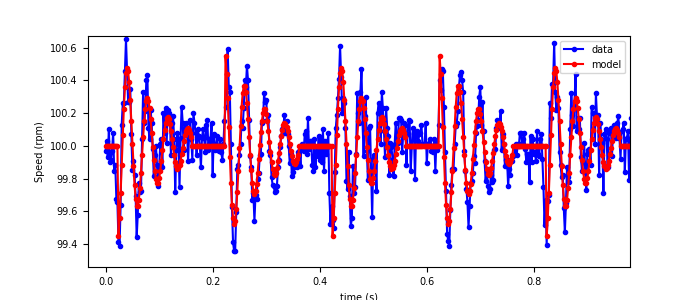

In [421]:
# plot resulting function

[A, t0, tau, omega, c, t1, t2, T, TT]=out

#plt.plot(t, h(out), '-ro')
plt.plot(t, v, '-b.', t, h(A, t0, tau, omega, c, t1, t2, T, TT), '-r.')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data','model'])
plt.show()

<IPython.core.display.Javascript object>


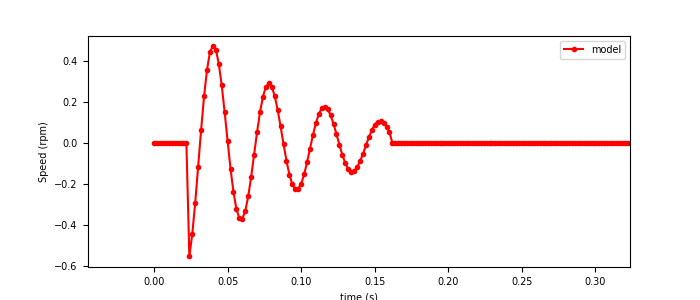

In [422]:
# for debug
# plt.plot(t,g(A, t0,tau, omega, c, t1, t2), '-r.')#,t, v, 'b-o')
# plt.xlabel('time (s)')
# plt.ylabel('Speed (rpm)')
# plt.legend(['model','data'])
# plt.show()

In [423]:
backlash_est = out[0]

-0.5942927600783237